**FINAL PROJECT PART 2: Indexing and Evaluation**

- Iria Quintero (254373)
- Javier González (243078)
- Mireia Pou (251725)


# Part 0: Imports and Drive

In [ ]:
#!pip install wordcloud

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer

import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import pandas as pd
import numpy as np
import math
from numpy import linalg as la

from collections import Counter
import itertools
import networkx as nx
from datetime import datetime

from collections import defaultdict
import time
from array import array
import collections

import zipfile
import json

import csv
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load a pre-trained NER model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
def normalize_vector(vec):
    norm = np.linalg.norm(vec)
    return vec / norm if norm > 0 else vec  # Avoid division by zero

# Part 1: Text Processing and Exploratory Data Analysis

## Part 1.1: Text Preprocessing

### Part 1.1.1 Data load

In [4]:
# Charging json data to variable data
# Specify name and path of .zip
zip_path = '/content/drive/Shareddrives/IRWA/Project/data/data.zip' #Change path to your own settings

# Open .zip
with zipfile.ZipFile(zip_path) as z:
    # Read JSON from .zip line by line
    with z.open('data/farmers-protest-tweets.json') as f:
        data = []  # Initialize an empty list to store the JSON objects
        for line in f:
            try:
                # Attempt to parse each line as a JSON object
                json_obj = json.loads(line)
                data.append(json_obj)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid line: {line} due to error: {e}")  # Print error and skip invalid lines


#Show JSON by printing a sample
print(f"Number of JSON objects loaded: {len(data)}")
if data:
    print("Sample JSON object:")
    print(data[0])

Number of JSON objects loaded: 117407
Sample JSON object:
{'url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198', 'date': '2021-02-24T09:23:35+00:00', 'content': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF', 'renderedContent': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur twitter.com/ravisinghka/st…', 'id': 1364506249291784198, 'user': {'username': 'ArjunSinghPanam', 'displayname': 'Arjun Singh Panam', 'id': 45091142, 'description': 'Global Citizen, Actor, Director: Sky is the roof above my head, the world is the road I travel, love is my food & mother earth is my

Function to read the doc id to tweet id map file

In [5]:
def load_docid_map_from_zip(zip_file_path, csv_file_name):
    docid_map = {}
    with zipfile.ZipFile(zip_file_path) as z:
        with z.open(csv_file_name) as file:
            reader = csv.DictReader(file.read().decode('utf-8').splitlines())  # Decode and read the lines
            for row in reader:
                docid_map[row['id']] = row['docId']  # Map 'id' to 'docId'
    return docid_map

In [6]:
docid_map = load_docid_map_from_zip(zip_path, 'data/tweet_document_ids_map.csv')

### 1.1.2 Text preprocessing functions

In [7]:
def build_terms(line):
    """
    Preprocess the text by removing stop words, stemming,
    transforming to lowercase, removing hashtags, and returning tokens.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    #stop_words.update(stopwords.words("hinglish"))  # Add Hindi stopwords
    stop_words.add("amp") # Add word amp to stop words since it is part of the & symbol

    # Start preprocessing
    line = line.lower()  # Convert to lowercase
    line = re.sub(r'[^a-z0-9\s]', '', line)  # Remove every symbol that is not a letter or a number
    line = line.split()  # Tokenize the text to get a list of terms
    # Remove punctuation
    line = [word.translate(str.maketrans('', '', string.punctuation)) for word in line]
    line = [item for item in line if item not in stop_words]  # Remove stopwords
    line = [word for word in line if len(word) > 1]  # Remove single-letter words
    line = [stemmer.stem(word) for word in line]  # Stemming
    return line

Function to get DocID | TweetID | Tweet Content | Tokenized Tweet | Date | Hashtags | Likes | Retweets | Url from a json tweet

In [8]:
def extract_tweet_info_with_docid(tweet_json, docid_map):
    # Extract the same fields as before
    tweet_id = tweet_json.get('id', '')
    doc_id = docid_map.get(str(tweet_id))  # Use str(tweet_id) to ensure proper matching

    if not doc_id:
        return None

    original_content = tweet_json.get('content', '')
    tokenized_content = build_terms(original_content)  # Apply text preprocessing
    tweet_date = tweet_json.get('date', '')

    hashtags = re.findall(r'#\w+', original_content)
    tweet_likes = tweet_json.get('likeCount', 0)
    tweet_retweets = tweet_json.get('retweetCount', 0)
    tweet_url = tweet_json.get('url', '')

    # Extract user information (username and follower count)
    user_info = tweet_json.get('user', {})
    username = user_info.get('username', 'unknown')
    followers_count = user_info.get('followersCount', 0)

    # Return the extracted information as a dictionary
    return {
        'DocID': doc_id,
        'TweetID': tweet_id,
        'Original Tweet': original_content,
        'Tokenized Tweet': tokenized_content,
        'Date': tweet_date,
        'Username': username,           # Twitter username
        'FollowersCount': followers_count,  # Number of followers
        'Hashtags': hashtags,
        'Likes': tweet_likes,
        'Retweets': tweet_retweets,
        'Url': tweet_url
    }

### 1.1.3 Tweet example

In [9]:
processed_data = []

for json_obj in data:
    # Create a copy of JSON original object
    processed_obj = json_obj.copy()  # Copia todos los campos del objeto JSON original

    # Check if content is in the object
    if 'content' in processed_obj:
        # Extraer información necesaria
        processed_obj = extract_tweet_info_with_docid(processed_obj, docid_map)

    # Add the processed object to the list if is not none
    if processed_obj is not None:
        processed_data.append(processed_obj)

# Shows a sample of the processed data
print(f"Number of JSON objects processed: {len(processed_data)}")
if processed_data:
    print("Sample processed data:")
    print(processed_data[0])

Number of JSON objects processed: 48429
Sample processed data:
{'DocID': 'doc_0', 'TweetID': 1364506249291784198, 'Original Tweet': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF', 'Tokenized Tweet': ['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', 'modidontsellfarm', 'farmersprotest', 'freenodeepkaur', 'httpstcoes3kn0iqaf'], 'Date': '2021-02-24T09:23:35+00:00', 'Username': 'ArjunSinghPanam', 'FollowersCount': 603, 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}


## Part 1.2: Exploratory Data Analysis

### 1.2.1 Basic statistics (topN words, word distribution, average sentence length)

In [ ]:
def print_top_n_words(processed_data, n):

    all_words = []

    # Gather all tokenized words from each tweet
    for tweet in processed_data:
        all_words.extend(tweet['Tokenized Tweet'])

    # Calculate frequency distribution of all words
    word_freq = FreqDist(all_words)

    # Get the top n most common words
    top_n = word_freq.most_common(n)

    # Dictionary to return word: frequency
    frec = {}
    for word, freq in top_n:
        frec[word] = freq  # Assign word as key and freq as value
    return frec

frec = print_top_n_words(processed_data, 10) # Take only the first 10 items
print("Top 10 most common words:")
for word, freq in list(frec.items()):
    print(f"{word}: {freq}")


Top 10 most common words:
farmersprotest: 50106
farmer: 17306
india: 7651
support: 5993
protest: 4766
modi: 3113
indian: 3001
govern: 2739
bjp: 2665
law: 2553


Word Counting Distribution

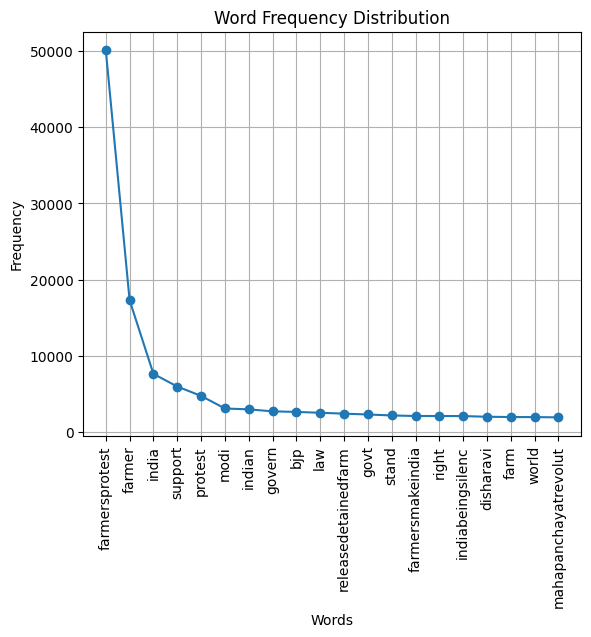

In [ ]:
def word_count_distribution(processed_data, n):

    # Get top words from previous function
    top_words = print_top_n_words(processed_data, n)

    # Make a plot
    plt.plot(top_words.keys(), top_words.values(), marker='o')
    plt.title("Word Frequency Distribution")
    plt.tight_layout()
    plt.xlabel("Words")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

word_count_distribution(processed_data, 20)

Function for computing the average sentence length

In [ ]:
def average_sentence_length(processed_data):
    sentence_lengths = [len(tweet['Tokenized Tweet']) for tweet in processed_data]
    avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
    print(f"Average Sentence Length: {avg_sentence_length}")

average_sentence_length(processed_data)


Average Sentence Length: 12.827603295546057


### 1.2.2 Word Cloud of topN words

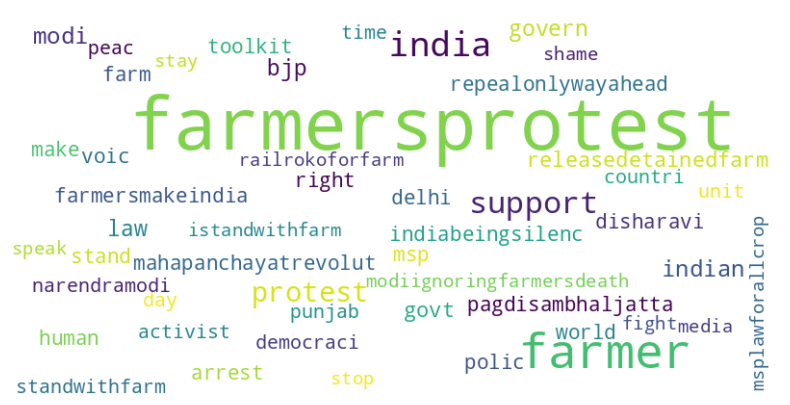

In [ ]:
# Generate the WordCloud
frec = print_top_n_words(processed_data, 50)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frec)

# Display the WordCloud
plt.figure(figsize=(10, 5))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the wordcloud image
plt.axis("off")  # Turn off axis labels and ticks
plt.show()  # Show the plot

### 1.2.3 Retweeted tweets

In [ ]:
def top_retweeted_tweets(processed_data, n):
    top_retweeted = sorted(processed_data, key=lambda x: x['Retweets'], reverse=True)[:n]
    print(f"Top {n} Tweets by Retweets:")
    i=1
    for tweet in top_retweeted:
        print(f"{i}. Tweet ID: {tweet['TweetID']} \nRetweets: {tweet['Retweets']} \nLikes: {tweet['Likes']} \nDate: {tweet['Date']}")
        print(f"Content: {tweet['Original Tweet']}\n")
        i= i+1

top_retweeted_tweets(processed_data, 10)

Top 10 Tweets by Retweets:
1. Tweet ID: 1364148079117615105 
Retweets: 6164 
Likes: 27888 
Date: 2021-02-23T09:40:21+00:00
Content: There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8

2. Tweet ID: 1360882069161803779 
Retweets: 4673 
Likes: 8974 
Date: 2021-02-14T09:22:23+00:00
Content: disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ

3. Tweet ID: 1360908603155050498 
Retweets: 3742 
Likes: 10403 
Date: 2021-02-14T11:07:50+00:00
Content: Disha Ravi broke down in court room and told judge that she had merely edited two lines in t

### 1.2.4 Entity recognition

In [ ]:
def entity_recognition(processed_data, n=5):

    nlp = spacy.load("en_core_web_sm")

    # Analyze named entities in the original tweets
    for tweet in processed_data[:n]:  # Analyze only the first few tweets
        words = tweet['Original Tweet']
        doc = nlp(words)

        print(f"Tweet ID: {tweet['TweetID']}")
        for ent in doc.ents:
            print(f"Entity: {ent.text}, Label: {ent.label_}")

entity_recognition(processed_data, 5)

Tweet ID: 1364506249291784198
Entity: Indian, Label: NORP
Entity: Govt, Label: ORG
Entity: India, Label: GPE
Entity: FarmersProtest, Label: MONEY
Tweet ID: 1364506237451313155
Entity: FarmersProtest, Label: ORG
Entity: #ModiIgnoringFarmersDeaths, Label: MONEY
Entity: Farmers, Label: ORG
Entity: India, Label: GPE
Entity: 🚜, Label: GPE
Entity: https://t.co/kLspngG9xE, Label: GPE
Tweet ID: 1364506167226032128
Entity: @ReallySwara, Label: CARDINAL
Entity: #farmersprotest #, Label: MONEY
Tweet ID: 1364505991887347714
Entity: #farmersprotest #NoFarmersNoFood, Label: MONEY
Tweet ID: 1364505813834989568
Entity: #farmersprotest #NoFarmersNoFood https://t.co/NFMJeQRTJ2, Label: MONEY


### 1.2.5 Other interesting statistics

#### 1.2.5.1 Most common hashtags and hashtags coocurrences

In [ ]:
def most_common_hashtags(processed_data, n=10):
  all_hashtags = []
  for tweet in processed_data:
    if 'Hashtags' in tweet and tweet['Hashtags']:
      all_hashtags.extend(tweet['Hashtags'])

  hashtag_counts = Counter(all_hashtags)
  most_common = hashtag_counts.most_common(n)

  print("Most common hashtags:")
  for hashtag, count in most_common:
    print(f"{hashtag}: {count}")

most_common_hashtags(processed_data, 20)

Most common hashtags:
#FarmersProtest: 45856
#ReleaseDetainedFarmers: 2430
#farmersprotest: 2305
#FarmersMakeIndia: 2129
#IndiaBeingSilenced: 2128
#MahapanchayatRevolution: 1939
#DishaRavi: 1914
#RepealOnlyWayAhead: 1751
#Pagdi_Sambhal_Jatta: 1581
#FarmersProtests: 1564
#ModiIgnoringFarmersDeaths: 1316
#StandWithFarmers: 1312
#MSPLawForAllCrops: 1271
#RailRokoForFarmers: 1259
#IStandWithFarmers: 1184
#Farmers: 1129
#FreeNodeepKaur: 1111
#FreeDishaRavi: 1034
#DPstopIntimidatingFarmers: 957
#India: 895


Hashtags cooccurences

In [ ]:
def hashtag_cooccurrence(processed_data, n):
    cooccurrence = Counter()

    # Get all combinations of hashtags from each tweet
    for tweet in processed_data:
        hashtags = tweet['Hashtags']
        if len(hashtags) > 1:
            for pair in itertools.combinations(hashtags, 2):
                cooccurrence[pair] += 1

    return cooccurrence.most_common(n)

# Example
n=20
cooccurrence = hashtag_cooccurrence(processed_data, n)

# Print the most common co-occurrences
print(f"Top {n} Hashtag Co-occurrences:")
for pair, count in cooccurrence:
   print(f"{pair}: {count}")

Top 20 Hashtag Co-occurrences:
('#FarmersProtest', '#ReleaseDetainedFarmers'): 1411
('#DishaRavi', '#FarmersProtest'): 1323
('#IndiaBeingSilenced', '#FarmersProtest'): 1249
('#FarmersMakeIndia', '#FarmersProtest'): 1130
('#Pagdi_Sambhal_Jatta', '#FarmersProtest'): 1060
('#FarmersProtest', '#MahapanchayatRevolution'): 1046
('#FarmersProtest', '#StandWithFarmers'): 1007
('#ReleaseDetainedFarmers', '#FarmersProtest'): 1000
('#FarmersProtest', '#FarmersMakeIndia'): 981
('#FarmersProtest', '#FarmersProtests'): 950
('#RepealOnlyWayAhead', '#FarmersProtest'): 881
('#MahapanchayatRevolution', '#FarmersProtest'): 832
('#FarmersProtest', '#IndiaBeingSilenced'): 828
('#MSPLawForAllCrops', '#FarmersProtest'): 828
('#FarmersProtest', '#RepealOnlyWayAhead'): 805
('#ModiIgnoringFarmersDeaths', '#FarmersProtest'): 765
('#RailRokoForFarmers', '#FarmersProtest'): 706
('#FarmersProtest', '#IStandWithFarmers'): 701
('#FarmersProtest', '#FarmersProtest'): 644
('#FreeNodeepKaur', '#FarmersProtest'): 630


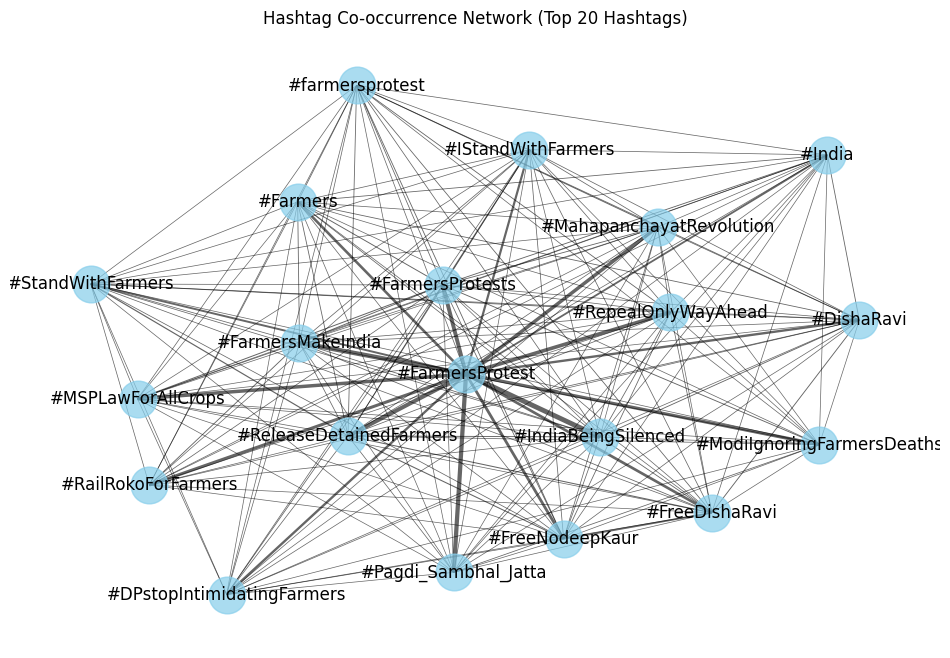

In [ ]:
def hashtag_cooccurrence_network(processed_data, n=20):

    cooccurrence = Counter()

    # Get all combinations of hashtags from each tweet
    for tweet in processed_data:
        hashtags = tweet['Hashtags']
        if len(hashtags) > 1:
            for pair in itertools.combinations(hashtags, 2):
                cooccurrence[pair] += 1

    # Create a graph from the co-occurrences
    G = nx.Graph()

    # Add edges to the graph based on co-occurrences
    for (hashtag1, hashtag2), count in cooccurrence.items():
        if count > 0 and hashtag1 != hashtag2:  # Only consider pairs with positive co-occurrences
            G.add_edge(hashtag1, hashtag2, weight=count)

    # Get the top n hashtags based on the number of occurrences
    hashtag_counts = Counter()
    for hashtags in processed_data:
        for hashtag in hashtags['Hashtags']:
            hashtag_counts[hashtag] += 1

    # Get the top n hashtags
    top_hashtags = [hashtag for hashtag, _ in hashtag_counts.most_common(n)]

    # Create a subgraph with only the top n hashtags
    top_edges = [(u, v) for u, v in G.edges() if u in top_hashtags and v in top_hashtags]
    top_G = G.edge_subgraph(top_edges).copy()

    # Draw the graph
    pos = nx.spring_layout(top_G)  # positions for all nodes
    weights = [top_G[u][v]['weight'] for u, v in top_G.edges()]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(top_G, pos, node_size=700, node_color='skyblue', alpha=0.7)

    # Adjust edge color and width for better visibility
    edge_color = 'black'
    edge_alpha = 0.6
    max_weight = max(weights) if weights else 1  # Avoid division by zero
    widths = [0.5 + 3 * (weight / max_weight) for weight in weights]  # Scale the weights for visibility

    nx.draw_networkx_edges(top_G, pos, width=widths, alpha=edge_alpha, edge_color=edge_color)
    nx.draw_networkx_labels(top_G, pos, font_size=12, font_family='sans-serif')

    plt.title(f"Hashtag Co-occurrence Network (Top {n} Hashtags)")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Example
hashtag_cooccurrence_network(processed_data, n=20)

#### 1.2.5.2 Most retweeted users

Preprocessing to add fields

In [ ]:
def extract_extended_tweet_info_with_docid(tweet_json, docid_map):
    # Extract the same fields as before
    tweet_id = tweet_json.get('id', '')
    doc_id = docid_map.get(str(tweet_id))  # Use str(tweet_id) to ensure proper matching

    if not doc_id:
        return None

    original_content = tweet_json.get('content', '')
    tokenized_content = build_terms(original_content)  # Apply text preprocessing
    tweet_date = tweet_json.get('date', '')

    hashtags = re.findall(r'#\w+', original_content)
    tweet_likes = tweet_json.get('likeCount', 0)
    tweet_retweets = tweet_json.get('retweetCount', 0)
    tweet_url = tweet_json.get('url', '')

    # Extract user information (username and follower count)
    user_info = tweet_json.get('user', {})
    username = user_info.get('username', 'unknown')
    followers_count = user_info.get('followersCount', 0)

    # Return the extracted information as a dictionary
    return {
        'DocID': doc_id,
        'TweetID': tweet_id,
        'Original Tweet': original_content,
        'Tokenized Tweet': tokenized_content,
        'Date': tweet_date,
        'Username': username,           # Twitter username
        'FollowersCount': followers_count,  # Number of followers
        'Hashtags': hashtags,
        'Likes': tweet_likes,
        'Retweets': tweet_retweets,
        'Url': tweet_url
    }

In [ ]:
extended_processed_data = []

for json_obj in data:
    # Crete a JSON object copy
    processed_obj = json_obj.copy()

    # Verify that "content" is present
    if 'content' in processed_obj:
        # Extract necessary informaiton
        processed_obj = extract_extended_tweet_info_with_docid(processed_obj, docid_map)

    # Add object if is not None
    if processed_obj is not None:
        extended_processed_data.append(processed_obj)

# show processed data
print(f"Number of JSON objects processed: {len(extended_processed_data)}")
if extended_processed_data:
    print("Sample processed data:")
    print(extended_processed_data[0])

Number of JSON objects processed: 48429
Sample processed data:
{'DocID': 'doc_0', 'TweetID': 1364506249291784198, 'Original Tweet': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF', 'Tokenized Tweet': ['world', 'progress', 'indian', 'polic', 'govt', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', 'modidontsellfarm', 'farmersprotest', 'freenodeepkaur', 'httpstcoes3kn0iqaf'], 'Date': '2021-02-24T09:23:35+00:00', 'Username': 'ArjunSinghPanam', 'FollowersCount': 603, 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'Likes': 0, 'Retweets': 0, 'Url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198'}


Most retweeted users

Top 10 Users with Most Retweeted Tweets:
User 1364148079117615105: 6164 retweets
Username: dhruv_rathee
Followers Count: 1025117
------------------------------
User 1360882069161803779: 4673 retweets
Username: rupikaur_
Followers Count: 268846
------------------------------
User 1360908603155050498: 3742 retweets
Username: amaanbali
Followers Count: 28255
------------------------------
User 1360162861419425795: 3332 retweets
Username: jedijasmin_
Followers Count: 847
------------------------------
User 1361790921902338048: 3230 retweets
Username: rupikaur_
Followers Count: 268846
------------------------------
User 1360260269646237699: 3182 retweets
Username: RaviSinghKA
Followers Count: 227429
------------------------------
User 1361037112783499264: 2495 retweets
Username: sushant_says
Followers Count: 200177
------------------------------
User 1363421524879843336: 2258 retweets
Username: amaanbali
Followers Count: 28254
------------------------------
User 1360893759173500930: 2208 re

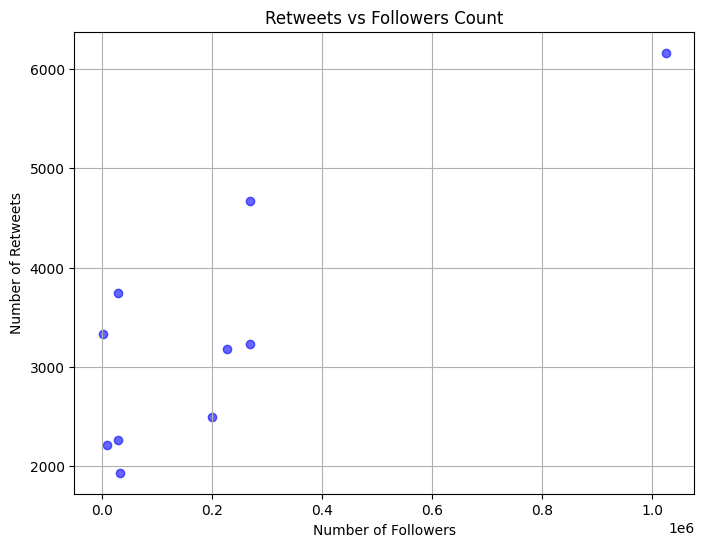

In [ ]:
def most_retweeted_users(extended_processed_data, top_n=10):

    # Dictionary to store total retweets for each user
    user_retweets = Counter()

    # Dictionary to store additional info for each user (e.g., username, followers)
    user_info = {}

    for tweet in extended_processed_data:
        user_id = tweet['TweetID']  # Unique tweet ID
        retweets = tweet['Retweets']  # Number of retweets
        username = tweet['Username']  # Username of the tweet author
        followers_count = tweet['FollowersCount']  # Number of followers

        # Add retweets count to the corresponding user
        user_retweets[user_id] += retweets

        # Store additional information about the user (only if not already stored)
        if user_id not in user_info:
            user_info[user_id] = {
                'username': username,
                'followers_count': followers_count
            }

    # Get the top N users with the most retweeted tweets
    most_retweeted = user_retweets.most_common(top_n)

    retweets_list = []
    followers_list = []

    # Print the most retweeted users with additional info
    print(f"Top {top_n} Users with Most Retweeted Tweets:")
    for user, retweets in most_retweeted:
        username = user_info[user]['username']
        followers_count = user_info[user]['followers_count']

        retweets_list.append(retweets)
        followers_list.append(followers_count)

        print(f"User {user}: {retweets} retweets")
        print(f"Username: {username}")
        print(f"Followers Count: {followers_count}")
        print("-" * 30)  # Just to separate the users visually

    # Plotting retweets vs followers
    plt.figure(figsize=(8, 6))
    plt.scatter(followers_list, retweets_list, color='blue', alpha=0.6)
    plt.title('Retweets vs Followers Count')
    plt.xlabel('Number of Followers')
    plt.ylabel('Number of Retweets')
    plt.grid(True)
    plt.show()

# Example usage
most_retweeted_users(extended_processed_data, top_n=10)


#### 1.2.5.3 Tweets time evolution

<ipython-input-23-c75d77b71214>:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  date_counts = date_series.dt.to_period(time_interval).value_counts().sort_index()


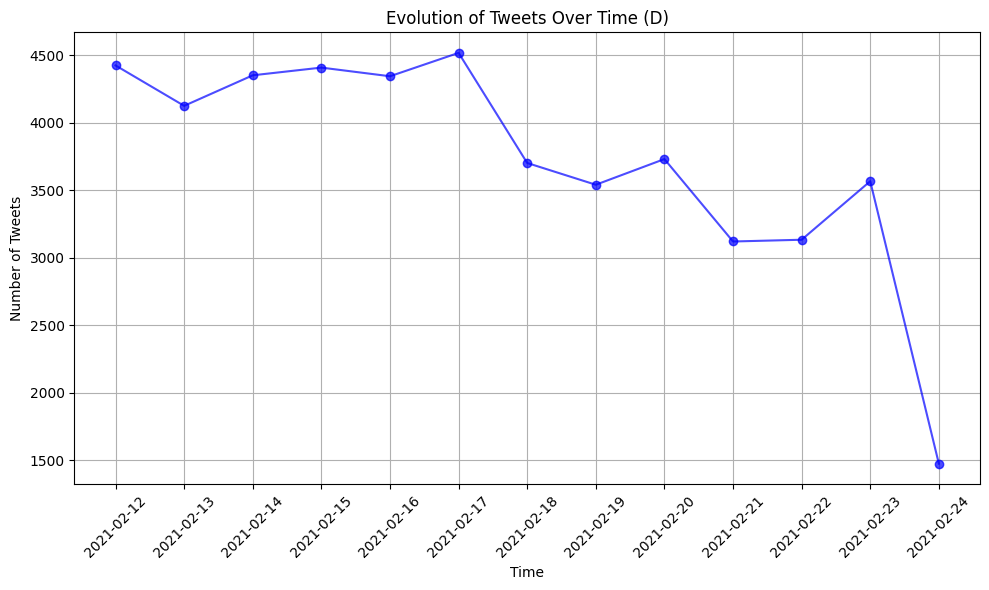

In [ ]:
def plot_tweets_over_time(extended_processed_data, time_interval='D'):

    # Extract dates from the tweets and convert them to datetime objects
    dates = [datetime.strptime(tweet['Date'], '%Y-%m-%dT%H:%M:%S%z') for tweet in extended_processed_data]

    # Convert dates to a pandas Series
    date_series = pd.Series(dates)

    # Group by the specified time interval ('D' for daily, 'W' for weekly, 'M' for monthly)
    date_counts = date_series.dt.to_period(time_interval).value_counts().sort_index()

    # Plotting the evolution of tweets over time
    plt.figure(figsize=(10, 6))
    plt.plot(date_counts.index.astype(str), date_counts.values, marker='o', color='blue', linestyle='-', alpha=0.7)
    plt.title(f'Evolution of Tweets Over Time ({time_interval})')
    plt.xlabel('Time')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_tweets_over_time(extended_processed_data, time_interval='D')

# Part 2: Indexing and Evaluation

## Part 2.1: Indexing

### Part 2.1.1: Inverted Index

In [10]:
def create_inverted_index(processed_data):
    """
    Creates an inverted index from preprocessed tweet data.

    Argument:
    processed_data -- list of dictionaries, each representing a preprocessed tweet

    Returns:
    inverted_index -- dictionary where the keys are terms and the values are lists of documents (DocID) where the terms appear
    """
    # Inverted index that will store {term: [list of DocIDs]}
    inverted_index = defaultdict(list)

    for tweet in processed_data:
        doc_id = tweet['DocID']  #document ID (tweet)
        terms = tweet['Tokenized Tweet']  #terms (already tokenized and preprocessed)

        # Build the inverted index
        for term in set(terms):  # Use set to avoid duplicate terms within the same document
            inverted_index[term].append(doc_id)  # Add the doc_id for the term

    # Optional: remove duplicates in the DocID lists
    for term in inverted_index:
        inverted_index[term] = list(set(inverted_index[term]))

    return inverted_index


In [11]:
start_time = time.time()
inverted_index = create_inverted_index(processed_data)
print("Total time to create the index: {} seconds".format(np.round(time.time() - start_time, 2)))

Total time to create the index: 0.45 seconds


In [12]:
print("Index results for the term 'police': {}\n".format(inverted_index['police']))
print("First 10 Index results for the term 'polic': \n{}".format(inverted_index['polic'][:10]))

Index results for the term 'police': []

First 10 Index results for the term 'polic': 
['doc_43542', 'doc_16731', 'doc_29333', 'doc_14499', 'doc_37457', 'doc_15050', 'doc_30752', 'doc_16535', 'doc_39360', 'doc_25058']


### Part 2.1.2: Querying

In [13]:
def search(query, index):
    """
    Output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = None  # Start with None to allow initialization by the first term
    for term in query:
        try:
            # Store in term_docs the ids of the docs that contain "term"
            term_docs = set(index[term])

            # Docs = docs Intersection term_docs (AND operation)
            if docs is None:
                docs = term_docs  # Initialize with the first term's docs
            else:
                docs = docs.intersection(term_docs)
        except KeyError:
            # If any term is not in the index, no documents contain all terms, return empty list
            return []

    # Convert docs to a list if it's not empty
    docs = list(docs) if docs else []

    return docs


Our 5 proposed queries are:
- India government farmers protest
- Increasing prices
- Narendra Modi (India's prime minister)
- Disha Ravi
- Anime

In [45]:
print("Insert your query (i.e.: Farmer Protest):\n")
query = input()
docs = search(query, inverted_index)
num2retrieve = 5

print("\n======================\nSample of {} results out of {} for the searched query:".format(num2retrieve, len(docs)))
for d_id in docs[:num2retrieve]:
    tweet_info = next((tweet for tweet in processed_data if tweet['DocID'] == d_id), None)

    if tweet_info:
        # Print the original content of the tweet
        print("\n----------------------\n")
        print("doc_id = {} \ndoc_content = {}".format(d_id, tweet_info['Original Tweet']))

Insert your query (i.e.: Farmer Protest):

Anime

Sample of 5 results out of 31 for the searched query:

----------------------

doc_id = doc_33877 
doc_content = Modi stray dogs can bark I m sorry throwing stone on a rabid animal is not my theory I will just put u out of ur misery 
U can't affect an ounce of my mental peace now keep on commenting 
#FarmersProtest #IndiaBeingSilenced

----------------------

doc_id = doc_38192 
doc_content = @ExtinctionR REBEL FOR SUSTAINABLE DEVELOPMENT by #UnitedForClimateXRHumanitysEmergencyServices  https://t.co/F6VWOjoZDh #SOLIDARITY Port Hope Simpson @dennisburden #Nature #Animals #StrongerTogether #ClimateJustice Is #ClimateActionNow PLANETARY EMERGENCY #FarmersProtest #FreeNavalny

----------------------

doc_id = doc_13262 
doc_content = FM urges industry to unleash animal spirits, make India fastest growing economy - The Hindu#farmers #farmersprotest

----------------------

doc_id = doc_41163 
doc_content = I Will create #YouTube #gaming #ba

### Part 2.1.3: Ranking with TF-IDF

In [16]:
def create_index_tfidf(processed_data):
    """
    Implement the inverted index and compute tf, df, and idf for a collection of tweets.

    Returns:
    index - the inverted index containing terms as keys and the corresponding
            list of documents these keys appear in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appears in
    idf - inverse document frequency of each term
    tweet_content_index - mapping of DocID to the original tweet content
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # Term frequencies of terms in documents
    df = defaultdict(int)  # Document frequencies of terms in the corpus
    tweet_content_index = defaultdict(str)  # Index for original tweet content
    num_documents = len(processed_data)  # Total number of documents (tweets)

    for tweet in processed_data:
        doc_id = tweet['DocID']
        terms = tweet['Tokenized Tweet']  # List of terms (already tokenized)
        original_tweet = tweet['Original Tweet']
        #tweet_content_index[doc_id] = original_tweet  # Store original tweet content (En principio esto no hace falta)

        ## Build the current tweet index for TF normalization and document frequency
        current_tweet_index = {}

        for position, term in enumerate(terms):  # Terms from the tokenized tweet
            if term not in current_tweet_index:
                current_tweet_index[term] = [doc_id, array('I', [position])] # this is an entry
            else:
                current_tweet_index[term][1].append(position)

        # Normalize term frequencies
        norm = 0
        for entry in current_tweet_index.values():
            norm += len(entry[1]) ** 2
        norm = math.sqrt(norm)

        # Calculate TF and DF weights
        for term, entry in current_tweet_index.items():
            tf[term].append(np.round(len(entry[1]) / norm, 4))  # TF calculation
            df[term] += 1  # Increment DF for current term

            # Merge the current tweet index with the main index
            index[term].append(entry)

    # Compute IDF following the formula
    idf = {}
    for term in df:
        idf[term] = np.round(np.log(float(num_documents) / df[term]), 4)

    return index, tf, df, idf#, tweet_content_index (en principio no hace falta y solo suma tiempo)


In [17]:
start_time = time.time()
index, tf, df, idf = create_index_tfidf(processed_data)
print("Total time to create the TF-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the TF-IDF index: 12.94 seconds


In [18]:
def rank_documents(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies

    Returns:
    Print the list of ranked documents
    """
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # Compute the norm for the query tf
    query_terms_count = collections.Counter(terms)
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):
        if term not in index:
            continue

        # Compute tf*idf (normalize TF as done with documents)
        query_vector[termIndex]= query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, entry in enumerate(index[term]):
            doc, postings = entry

            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # Calculate the score of each doc
    # Compute the cosine similarity between queyVector and each docVector:

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]

    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)

    return result_docs, doc_scores

In [19]:
def search_tf_idf(query, index):
    """
    Output is the list of documents that contain all of the query terms.
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = None  # Start with None to allow initialization by the first term
    for term in query:
        try:
            # Store in term_docs the ids of the docs that contain "term"
            term_docs = set(posting[0] for posting in index[term])
            #print(term_docs)
            # docs = docs Intersection term_docs (AND operation)
            if docs is None:
                docs = term_docs  # Initialize with the first term's docs
            else:
                docs = docs.intersection(term_docs)
        except KeyError:
            # If any term is not in the index, no documents contain all terms, return empty list
            return []

    # Convert docs to a list if it's not empty
    docs = list(docs)

    # Rank the resulting documents
    ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf)
    return ranked_docs, doc_scores


In [43]:
print("Insert your query (i.e.: Disha Ravi):\n")
query = input()
docs, score = search_tf_idf(query, index)
top = 10

print("\n======================\nTop {} results out of {} ranked documents for the searched query:".format(top, len(docs)))
for d_id in docs[:top]:
    tweet_info = next((tweet for tweet in processed_data if tweet['DocID'] == d_id), None)

    if tweet_info:
        # Print the original content of the tweet
        print("\n----------------------\n")
        print("doc_id = {} \ndoc_content = {}".format(d_id, tweet_info['Original Tweet']))

Insert your query (i.e.: Disha Ravi):

Anime

Top 10 results out of 31 ranked documents for the searched query:

----------------------

doc_id = doc_45935 
doc_content = All animals are equal but some animals are more equal than others.
#FarmersProtest https://t.co/4NtTKIj2sF

----------------------

doc_id = doc_34980 
doc_content = All Men Are Enemies. All Animals Are Comrades: George Orwell's #Toolkit For Rebellion

Be A #Bookaanan, Read
Animal Farm
https://t.co/gwARnQCJn8
#Nationalism #FarmersProtest #inquilab #inquilabzindabad #IndiaTogether #IndiaBeingSilenced #GretaThunberg #Khalistan #Dystopian #india https://t.co/yRXUw4jys0

----------------------

doc_id = doc_1565 
doc_content = The guy wearing blue turban is my spirit animal.

#FarmersProtest https://t.co/0iX9YaLNmW

----------------------

doc_id = doc_9089 
doc_content = Humans and animals both are not safe in this country anymore

This is an era of inhumans

#ModiGlobalDisaster 
#FarmersProtest

----------------------



## Part 2.2: Evaluation

Provided evaluation ground truth:

In [22]:
# Open the ZIP file and read the CSV directly
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('data/evaluation_gt.csv') as file:
        # Load the CSV file directly from the ZIP into a DataFrame
        ground_truth_df = pd.read_csv(file)

# Split the single column into three columns as before
ground_truth_df[['docId', 'query_id', 'label']] = ground_truth_df['docId;query_id;label'].str.split(';', expand=True)
ground_truth_df = ground_truth_df.drop(columns=['docId;query_id;label'])
ground_truth_df.head()

,docId,query_id,label
0,doc_156,1,0
1,doc_1039,1,0
2,doc_1047,1,1
3,doc_1685,1,0
4,doc_2100,1,1


Our own ground truth:

In [23]:
# Open the ZIP file and read the CSV directly
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('data/self_evaluation.csv') as file:
        # Load the CSV file directly from the ZIP into a DataFrame
        self_ground_truth_df = pd.read_csv(file)

self_ground_truth_df.head()

,docId,query_id,label
0,doc_40320,1,1
1,doc_3431,1,1
2,doc_8933,1,1
3,doc_45320,1,1
4,doc_30206,1,1


### Part 2.2.1: Evaluation Functions

In [24]:
# Precision@k
def precision_at_k(ground_truth, predicted, k):
    order = np.argsort(predicted)[::-1]
    ground_truth = np.take(ground_truth, order[:k])
    predicted_top_k = np.take(predicted, order[:k])
    relevant = sum((ground_truth == 1) & (predicted_top_k > 0))
    return float(relevant) / k

# Recall@k
def recall_at_k(ground_truth, predicted, k):
    order = np.argsort(predicted)[::-1]
    ground_truth_k = np.take(ground_truth, order[:k])
    predicted_top_k = np.take(predicted, order[:k])
    relevant = sum((ground_truth_k == 1) & (predicted_top_k > 0))
    total_relevant = sum(ground_truth == 1)
    if total_relevant == 0:
        return 0.0
    else:
        return float(relevant) / total_relevant

# Average Precision@k
def average_precision_at_k(ground_truth, predicted, k):

    order = np.argsort(predicted)[::-1]  # Let the list of indexes of the predicted score sorted in descending order.
    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))
    for i in range(number_to_iterate):
      if (ground_truth[order[i]] == 1) & (predicted[order[i]] > 0):
          number_of_relevant += 1
          prec_at_i = number_of_relevant / (i + 1)
          prec_at_i_list.append(prec_at_i)
    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

# F1 Score@k
def f1_score_at_k(ground_truth, predicted, k):
    precision = precision_at_k(ground_truth, predicted, k)
    recall = recall_at_k(ground_truth, predicted, k)
    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0.0

# Reciprocal Rank@k (MRR)
def rr_at_k(ground_truth, predicted, k=10):
    order = np.argsort(predicted)[::-1]
    ground_truth = np.take(ground_truth, order[:k])
    predicted_top_k = np.take(predicted, order[:k])
    if np.sum((ground_truth == 1) & (predicted_top_k > 0)) == 0:
        return 0
    return 1 / (np.argmax((ground_truth == 1) & (predicted_top_k > 0)) + 1)

# DCG@k
def dcg_at_k(ground_truth, predicted, k=10):
    order = np.argsort(predicted)[::-1]
    ground_truth = np.take(ground_truth, order[:k])
    predicted_top_k = np.take(predicted, order[:k])
    gain = (2 ** ground_truth - 1) * (predicted_top_k > 0)
    discounts = np.log2(np.arange(len(ground_truth)) + 2)
    return np.sum(gain / discounts)

# NDCG@k
def ndcg_at_k(ground_truth, predicted, k=10):
    dcg_max = dcg_at_k(ground_truth, ground_truth, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(ground_truth, predicted, k) / dcg_max, 4)


In [25]:
def mean_average_precision_at_k(all_ground_truth, all_predicted, k):
    """
    Parameters:
    - all_ground_truth: list of ground truth lists for each query
    - all_predicted: list of predicted scores lists for each query
    - k: cutoff rank for evaluation

    Returns:
    - mean average precision at k for all queries
    """
    average_precisions = []
    for ground_truth, predicted in zip(all_ground_truth, all_predicted):
      avg_precision = average_precision_at_k(list(ground_truth), list(predicted), k)
      average_precisions.append(avg_precision)

    # Calculate the mean of average precisions
    return np.mean(average_precisions)

def mean_reciprocal_rank_at_k(all_ground_truth, all_predicted, k):
    """
    Parameters:
    - all_ground_truth: list of ground truth lists for each query
    - all_predicted: list of predicted scores lists for each query
    - k: cutoff rank for evaluation

    Returns:
    - mean reciprocal rank at k for all queries
    """
    reciprocal_ranks = []
    for ground_truth, predicted in zip(all_ground_truth, all_predicted):
        rr = rr_at_k(ground_truth.to_numpy(), predicted.to_numpy(), k)
        reciprocal_ranks.append(rr)

    # Calculate the mean of reciprocal ranks
    return np.mean(reciprocal_ranks)

In [26]:
# Function with procedure to evaluate queries

def evaluate_query(query, query_id, ground_truth, index, k_array, own_query):
  # Get only ground_truth for query_id
  if own_query == True:
    # In our dataset query id is an int
    ground_truth = ground_truth[ground_truth['query_id'] == query_id]
  else:
    ground_truth = ground_truth[ground_truth['query_id'] == str(query_id)]
    ground_truth['label'] = ground_truth['label'].astype(int) #change to integer

  #ground_truth_q1.head()

  # Get predicted relevance (predicted relevance --> doc_score)
  docs_ranked, doc_score = search_tf_idf(query, index)

  #print("Predicted rank for query 1:", docs_ranked)
  #print("Predicted relevance for query 1:", doc_score)

  # Normalize using Min-Max Scaling
  relevance_scores = [score[0] for score in doc_score]
  min_score = np.min(relevance_scores)
  max_score = np.max(relevance_scores)
  normalized_relevance = [(score - min_score) / (max_score - min_score) for score in relevance_scores]

  # Update the original list with normalized values
  normalized_doc_score = [[normalized_relevance[i], doc_score[i][1]] for i in range(len(doc_score))]
  # Last doc score normalized is 0, instead get previous doc score /2
  normalized_doc_score[-1][0] = (normalized_doc_score[-2][0] / 2)

  #print("Predicted relevance for query 1:", normalized_doc_score)

  # Create complete dataframe
  predicted_df = pd.DataFrame(normalized_doc_score, columns=['predicted_relevance', 'docId'])

  # Merge DataFrames on 'docId'
  ground_truth_complete = ground_truth.merge(predicted_df, on='docId', how='left')
  ground_truth_complete['predicted_relevance'] = ground_truth_complete['predicted_relevance'].fillna(0)

  #ground_truth_complete.head()

  #EVALUATION
  # Arguments
  arg1= np.array(ground_truth_complete["label"]) # Ground truth given to us
  arg2= np.array(ground_truth_complete["predicted_relevance"]) # Predicted cosine similarity

  print("\n")
  for k in k_array:
    # Functions
    print(f"Precision@{k}:", precision_at_k(arg1, arg2, k))
    print(f"Recall@{k}:", recall_at_k(arg1, arg2, k))
    avg_precision_k = average_precision_at_k(arg1, arg2, k)
    print(f"Average Precision@{k}:", avg_precision_k)
    print(f"F1-Score@{k}:", f1_score_at_k(arg1, arg2, k))
    print(f"NDCG@{k}:", ndcg_at_k(arg1, arg2, k))
    print("\n")

In [27]:
# Function to evaluate map and mrr
def evaluate_map_mrr(ground_truth, query_list, query_id_list, k_array, own_query):
  all_ground_truth = []
  all_predicted = []

  for query, query_id in zip(query_list, query_id_list):
    # Get only ground_truth for query_id
    if own_query == True:
      # In our dataset query id is an int
      ground_truth_query = ground_truth[ground_truth['query_id'] == query_id]
    else:
      ground_truth_query = ground_truth[ground_truth['query_id'] == str(query_id)]
      ground_truth_query['label'] = ground_truth_query['label'].astype(int) #change to integer


    docs_ranked, doc_score = search_tf_idf(query, index)

    # Normalize using Min-Max Scaling
    relevance_scores = [score[0] for score in doc_score]
    min_score = np.min(relevance_scores)
    max_score = np.max(relevance_scores)
    normalized_relevance = [(score - min_score) / (max_score - min_score) for score in relevance_scores]

    # Update the original list with normalized values
    normalized_doc_score = [[normalized_relevance[i], doc_score[i][1]] for i in range(len(doc_score))]
    # Last doc score normalized is 0, instead get previous doc score /2
    normalized_doc_score[-1][0] = (normalized_doc_score[-2][0] / 2)

    #print("Predicted relevance for query 1:", normalized_doc_score)

    # Create complete dataframe
    predicted_df = pd.DataFrame(normalized_doc_score, columns=['predicted_relevance', 'docId'])

    # Merge DataFrames on 'docId'
    ground_truth_complete = ground_truth_query.merge(predicted_df, on='docId', how='left')
    ground_truth_complete['predicted_relevance'] = ground_truth_complete['predicted_relevance'].fillna(0)

    all_ground_truth.append(ground_truth_complete["label"])
    all_predicted.append(ground_truth_complete["predicted_relevance"])

  print("\n")
  for k in k_array:
    # Functions
    print(f"MAP@{k}:", mean_average_precision_at_k(list(all_ground_truth), list(all_predicted), k))
    print(f"MRR@{k}:", mean_reciprocal_rank_at_k(all_ground_truth, all_predicted, k))
    print("\n")

### Part 2.2.2: Provided queries evaluation

In [28]:
query_1 = "what are the people's rights?"
query_2 = 'what is being said about the Indian government?'
query_2_new = 'what is being about the Indian government?' #without said

In [29]:
k_array = [5, 10, 15, 20]

Evaluation of query 1:

In [30]:
evaluate_query(query_1, 1, ground_truth_df, index, k_array, False)



Precision@5: 0.8
Recall@5: 0.26666666666666666
Average Precision@5: 0.95
F1-Score@5: 0.4
NDCG@5: 0.8539


Precision@10: 0.8
Recall@10: 0.5333333333333333
Average Precision@10: 0.8552579365079365
F1-Score@10: 0.64
NDCG@10: 0.8268


Precision@15: 0.8666666666666667
Recall@15: 0.8666666666666667
Average Precision@15: 0.8510416933493858
F1-Score@15: 0.8666666666666667
NDCG@15: 0.8658


Precision@20: 0.7
Recall@20: 0.9333333333333333
Average Precision@20: 0.8527530009672868
F1-Score@20: 0.8
NDCG@20: 0.9075




<ipython-input-26-7d97b98b42b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth['label'] = ground_truth['label'].astype(int) #change to integer


Evaluation of query 2:

In [31]:
evaluate_query(query_2, 2, ground_truth_df, index, k_array, False)



Precision@5: 0.0
Recall@5: 0.0
Average Precision@5: 0
F1-Score@5: 0.0
NDCG@5: 0.0


Precision@10: 0.0
Recall@10: 0.0
Average Precision@10: 0
F1-Score@10: 0.0
NDCG@10: 0.0


Precision@15: 0.0
Recall@15: 0.0
Average Precision@15: 0
F1-Score@15: 0.0
NDCG@15: 0.0


Precision@20: 0.0
Recall@20: 0.0
Average Precision@20: 0
F1-Score@20: 0.0
NDCG@20: 0.0




<ipython-input-26-7d97b98b42b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth['label'] = ground_truth['label'].astype(int) #change to integer


**Everything is 0 because the query also considers the word "said"!!!!**  Because of this, we propose to evaluate this query without the "said".

Evaluation of new query 2

In [32]:
evaluate_query(query_2_new, 2, ground_truth_df, index, k_array, False)



Precision@5: 1.0
Recall@5: 0.3333333333333333
Average Precision@5: 1.0
F1-Score@5: 0.5
NDCG@5: 1.0


Precision@10: 1.0
Recall@10: 0.6666666666666666
Average Precision@10: 1.0
F1-Score@10: 0.8
NDCG@10: 1.0


Precision@15: 0.9333333333333333
Recall@15: 0.9333333333333333
Average Precision@15: 1.0
F1-Score@15: 0.9333333333333333
NDCG@15: 0.9573


Precision@20: 0.7
Recall@20: 0.9333333333333333
Average Precision@20: 1.0
F1-Score@20: 0.8
NDCG@20: 0.9573




<ipython-input-26-7d97b98b42b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth['label'] = ground_truth['label'].astype(int) #change to integer


Mean evaluations (MAP, MRR)

In [33]:
query_list = [query_1, query_2_new]
query_id_list = [1, 2]
evaluate_map_mrr(ground_truth_df, query_list, query_id_list, k_array, False)



MAP@5: 0.975
MRR@5: 1.0


MAP@10: 0.9276289682539682
MRR@10: 1.0


MAP@15: 0.9255208466746929
MRR@15: 1.0


MAP@20: 0.9263765004836434
MRR@20: 1.0




<ipython-input-27-b1df30de4e8b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_query['label'] = ground_truth_query['label'].astype(int) #change to integer
<ipython-input-27-b1df30de4e8b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth_query['label'] = ground_truth_query['label'].astype(int) #change to integer


### Part 2.2.3 Evaluation for proposed 5 queries

In [34]:
our_query_1 = "India government farmers protest"
our_query_2 = 'Increasing prices'
our_query_3 = 'Narendra Modi'
our_query_4 = 'Disha Ravi'
our_query_5 = 'Anime'

In [35]:
k_array = [5, 10, 15, 20]

Evaluation of query 1:

In [36]:
evaluate_query(our_query_1, 1, self_ground_truth_df, index, k_array, True)



Precision@5: 0.4
Recall@5: 0.2
Average Precision@5: 0.41666666666666663
F1-Score@5: 0.26666666666666666
NDCG@5: 0.3156


Precision@10: 0.2
Recall@10: 0.2
Average Precision@10: 0.41666666666666663
F1-Score@10: 0.20000000000000004
NDCG@10: 0.2048


Precision@15: 0.13333333333333333
Recall@15: 0.2
Average Precision@15: 0.41666666666666663
F1-Score@15: 0.16
NDCG@15: 0.2048


Precision@20: 0.1
Recall@20: 0.2
Average Precision@20: 0.41666666666666663
F1-Score@20: 0.13333333333333333
NDCG@20: 0.2048




Evaluation of query 2:

In [37]:
evaluate_query(our_query_2, 2, self_ground_truth_df, index, k_array, True)



Precision@5: 1.0
Recall@5: 0.5
Average Precision@5: 1.0
F1-Score@5: 0.6666666666666666
NDCG@5: 1.0


Precision@10: 0.5
Recall@10: 0.5
Average Precision@10: 1.0
F1-Score@10: 0.5
NDCG@10: 0.6489


Precision@15: 0.3333333333333333
Recall@15: 0.5
Average Precision@15: 1.0
F1-Score@15: 0.4
NDCG@15: 0.6489


Precision@20: 0.25
Recall@20: 0.5
Average Precision@20: 1.0
F1-Score@20: 0.3333333333333333
NDCG@20: 0.6489




Evaluation of query 3:

In [38]:
evaluate_query(our_query_3, 3, self_ground_truth_df, index, k_array, True)



Precision@5: 0.0
Recall@5: 0.0
Average Precision@5: 0
F1-Score@5: 0.0
NDCG@5: 0.0


Precision@10: 0.0
Recall@10: 0.0
Average Precision@10: 0
F1-Score@10: 0.0
NDCG@10: 0.0


Precision@15: 0.0
Recall@15: 0.0
Average Precision@15: 0
F1-Score@15: 0.0
NDCG@15: 0.0


Precision@20: 0.0
Recall@20: 0.0
Average Precision@20: 0
F1-Score@20: 0.0
NDCG@20: 0.0




Evaluation of query 4:

In [46]:
evaluate_query(our_query_4, 4, self_ground_truth_df, index, k_array, True)



Precision@5: 0.0
Recall@5: 0.0
Average Precision@5: 0
F1-Score@5: 0.0
NDCG@5: 0.0


Precision@10: 0.1
Recall@10: 0.125
Average Precision@10: 0.125
F1-Score@10: 0.11111111111111112
NDCG@10: 0.0798


Precision@15: 0.2
Recall@15: 0.375
Average Precision@15: 0.15595238095238095
F1-Score@15: 0.26086956521739135
NDCG@15: 0.2078


Precision@20: 0.4
Recall@20: 1.0
Average Precision@20: 0.2642161469851098
F1-Score@20: 0.5714285714285715
NDCG@20: 0.506




Evaluation of query 5:

In [47]:
evaluate_query(our_query_5, 5, self_ground_truth_df, index, k_array, True)



Precision@5: 0.0
Recall@5: 0.0
Average Precision@5: 0
F1-Score@5: 0.0
NDCG@5: 0


Precision@10: 0.0
Recall@10: 0.0
Average Precision@10: 0
F1-Score@10: 0.0
NDCG@10: 0


Precision@15: 0.0
Recall@15: 0.0
Average Precision@15: 0
F1-Score@15: 0.0
NDCG@15: 0


Precision@20: 0.0
Recall@20: 0.0
Average Precision@20: 0
F1-Score@20: 0.0
NDCG@20: 0




### Part 2.2.4 T-SNE

####Part 2.2.4.1. T-SNE representation function

In [48]:
# Function to convert each tweet to a single vector by averaging word vectors
def tweet_to_vector(tweet, word2vec_model):
    word_vectors = [word2vec_model.wv[word] for word in tweet if word in word2vec_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(word2vec_model.vector_size)

def Tsne_visualization (processed_data, query_num):
    # Sample data (replace this with your processed data)
    data = pd.DataFrame(processed_data)  # assuming `processed_data` is the list of processed tweet dictionaries

    # Prepare the sentences for Word2Vec
    sentences = data['Tokenized Tweet'].tolist()  # list of lists of tokenized words

    # Train Word2Vec model
    word2vec_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    # Apply the function to each tweet in the dataset
    tweet_vectors = np.array([tweet_to_vector(tweet, word2vec_model) for tweet in sentences])

    # Dimensionality reduction with T-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tweet_embeddings_2d = tsne.fit_transform(tweet_vectors)

    # Optionally, try PCA as an alternative to T-SNE for comparison
    #pca = PCA(n_components=2)
    #tweet_embeddings_2d = pca.fit_transform(tweet_vectors)

    # Plotting the T-SNE or PCA results
    plt.figure(figsize=(10, 6))
    plt.scatter(tweet_embeddings_2d[:, 0], tweet_embeddings_2d[:, 1], s=10, alpha=0.7)
    plt.title(f"2D representation of Tweets obtained for query {query_num} using TSNE")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

####Part 2.2.4.2: Query 1: what are the people's rights?

In [49]:
# Create a list with doc_ids of results of this query
query = "what are the people's rights?"
docs_q1, _ = search_tf_idf(query, index)
processed_data_q1 = [tweet for tweet in processed_data if tweet['DocID'] in docs_q1]
print(len(processed_data_q1))

283


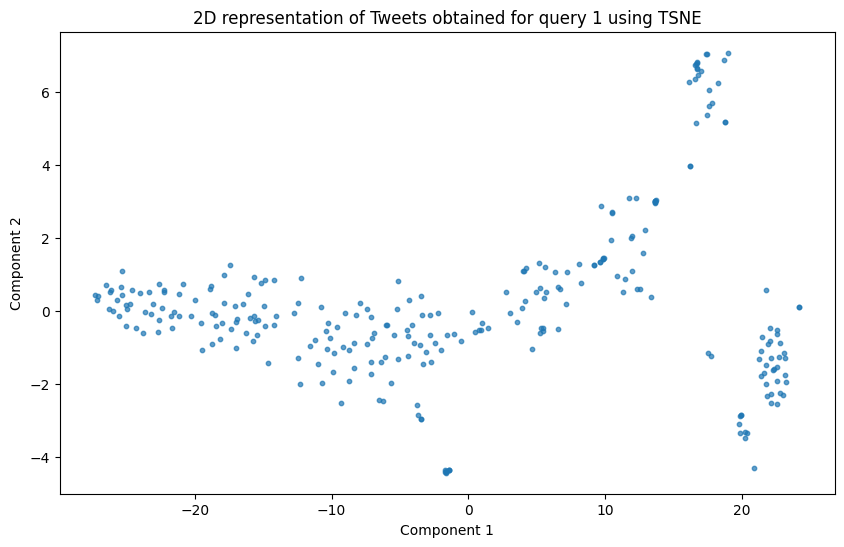

In [50]:
Tsne_visualization(processed_data_q1, 1)

####Part 2.2.4.3: Query 2: Narendra Modi



In [51]:
# Create a list with doc_ids of results of this query
q2= "Narendra Modi"
docs_q2, _ = search_tf_idf(q2, index)
processed_data_q2 = [tweet for tweet in processed_data if tweet['DocID'] in docs_q2]
print(len(processed_data_q2))

70


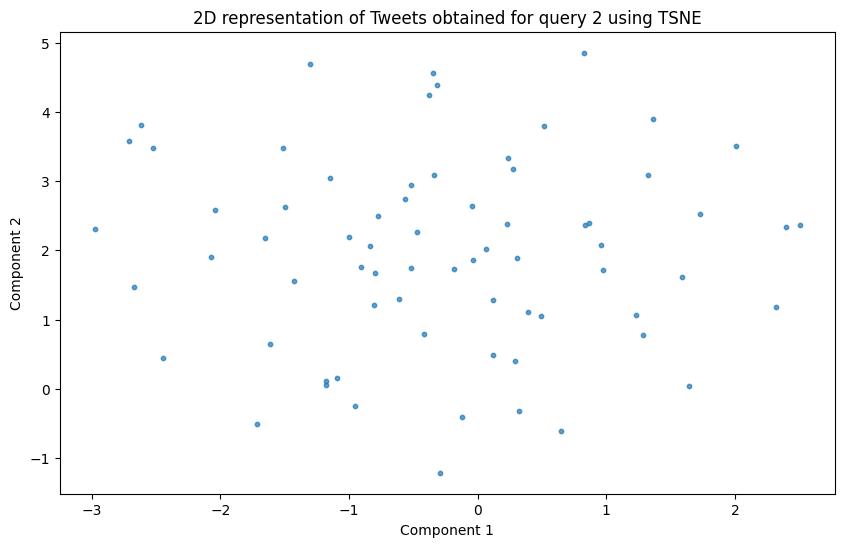

In [52]:
Tsne_visualization(processed_data_q2, 2)

####Part 2.2.4.4: Query 3: Disha Ravi

In [55]:
# Create a list with doc_ids of results of this query
q3 = "Disha Ravi"
docs_q3, _ = search_tf_idf(q3, index)
processed_data_q3 = [tweet for tweet in processed_data if tweet['DocID'] in docs_q3]
print(len(processed_data_q3))

628


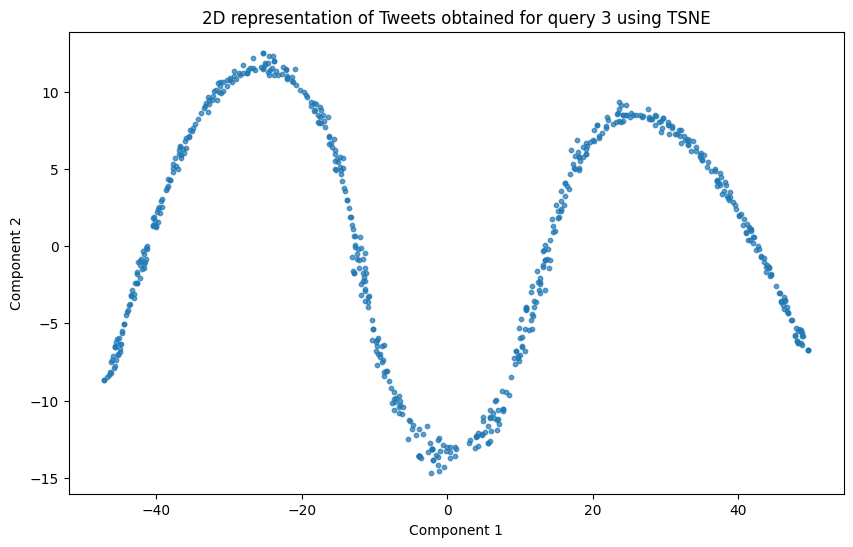

In [56]:
Tsne_visualization(processed_data_q3, 3)

####Part 2.2.4.5: Query 4: Increasing Prices

In [57]:
# Create a list with doc_ids of results of this query
q4 = "Increasing Prices"
docs_q4, _ = search_tf_idf(q4, index)
processed_data_q4 = [tweet for tweet in processed_data if tweet['DocID'] in docs_q4]
print(len(processed_data_q4))

109


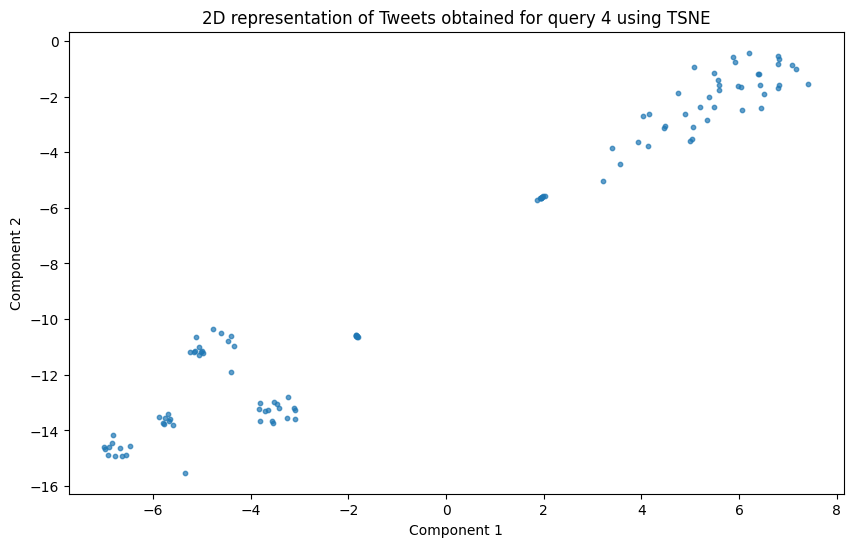

In [59]:
Tsne_visualization(processed_data_q4, 4)